In [79]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

In [80]:
#Assign column names to my data because it doesn't have any

column_names = ['Year', 'Month', 'Day', 'Index1', 'Index2', 'Phase', 'Amplitude']

# Read the MJO.txt file
mjo_data = pd.read_csv("/home/jstancz/data/MJO.txt", sep='\s+', header=None, names=column_names)

# Display the first few rows
print(mjo_data)

      Year  Month  Day   Index1   Index2  Phase  Amplitude
0     2011      1    1  0.31961  0.17840      3   0.366029
1     2011      1    2  0.25930  0.17280      3   0.311603
2     2011      1    3  0.19034  0.18693      3   0.266781
3     2011      1    4  0.11360  0.22080      4   0.248309
4     2011      1    5  0.03045  0.27281      4   0.274504
...    ...    ...  ...      ...      ...    ...        ...
2643  2018      3   28 -1.38235  0.82949      6   1.612124
2644  2018      3   29 -1.41948  0.78580      6   1.622469
2645  2018      3   30 -1.43539  0.70210      6   1.597902
2646  2018      3   31 -1.42788  0.57662      6   1.539913
2647  2018      4    1 -1.39443  0.41067      6   1.453645

[2648 rows x 7 columns]


In [81]:
# Create separate DataFrames for each phase (1 through 8)

phase_1 = mjo_data[mjo_data['Phase'] == 1]
phase_2 = mjo_data[mjo_data['Phase'] == 2]
phase_3 = mjo_data[mjo_data['Phase'] == 3]
phase_4 = mjo_data[mjo_data['Phase'] == 4]
phase_5 = mjo_data[mjo_data['Phase'] == 5]
phase_6 = mjo_data[mjo_data['Phase'] == 6]
phase_7 = mjo_data[mjo_data['Phase'] == 7]
phase_8 = mjo_data[mjo_data['Phase'] == 8]

In [82]:
phase_1

,Year,Month,Day,Index1,Index2,Phase,Amplitude
27,2011,1,28,0.00099,-0.97668,1,0.976680
28,2011,1,29,0.15483,-0.87904,1,0.892571
29,2011,1,30,0.29676,-0.75875,1,0.814720
30,2011,1,31,0.42139,-0.62712,1,0.755546
40,2011,2,10,0.21472,-0.36721,1,0.425380
...,...,...,...,...,...,...,...
2605,2018,2,18,0.49759,-1.45714,1,1.539757
2606,2018,2,19,0.62118,-1.29834,1,1.439288
2607,2018,2,20,0.71835,-1.14706,1,1.353430
2608,2018,2,21,0.79513,-1.00255,1,1.279585


In [83]:
#Read in precipitation file
file='/home/jstancz/Desktop/groups/ORC-CLIMATE/aoes_repo/obs/MSWEP_daily/MSWEP_201*.nc/'
ds_precip = xr.open_mfdataset(file,combine='nested',concat_dim='time')
ds_precip

<xarray.Dataset>
Dimensions:    (time: 3652, latitude: 73, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2019-12-31
  * latitude   (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(365, 73, 144), meta=np.ndarray>

In [84]:
# Calculate the climatology
ds_precip_clim = ds_precip.groupby('time.month').mean('time')

# Calculate anomalies
ds_precip_anom = ds_precip.groupby('time.month') - ds_precip_clim

In [85]:
ds_precip_anom

<xarray.Dataset>
Dimensions:    (time: 3652, latitude: 73, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2019-12-31
  * latitude   (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    month      (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(31, 73, 144), meta=np.ndarray>

In [86]:
# Convert the time to pd datetime
mjo_data['Date'] = pd.to_datetime(mjo_data[['Year', 'Month', 'Day']])

# Convert time values in ds_precip_anom to pd datetime
ds_precip_anom['time'] = pd.to_datetime(ds_precip_anom['time'].values)



# Create dictionary to store composites for each phase
phase_composites = {}
#Store the actual anomaly data including time for each phase for t-testing later
phase_anomalies = {}




# Loop through each phase and extract precip anomaly data for these dates
for phase in range(1, 9):
    
    # Filter for dates in the current phase
    phase_dates = mjo_data.loc[mjo_data['Phase'] == phase, 'Date']
    
    # precipitation anomalies for these dates
    anomalies = ds_precip_anom.sel(time=ds_precip_anom['time'].isin(phase_dates))
    
    # Calculate the composite precipitation anomaly
    phase_composites[f'phase_{phase}'] = anomalies.mean(dim='time')
    
    #Store the anomalies for each phase into the phase_anomalies dictionary
    phase_anomalies[f'phase_{phase}'] = anomalies

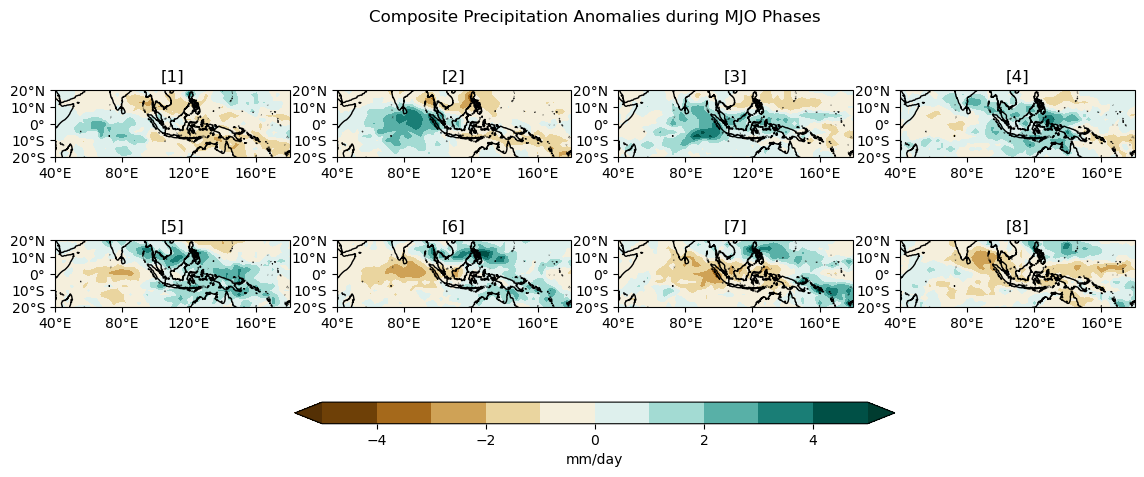

In [87]:
clevs = np.arange(-5.0,5.1, 1)  # Define contour levels for precipitation anomalies

# Define the figure and axes for the subplots (one for each MJO phase)
fig, axs = plt.subplots(nrows=2, ncols=4,
                        figsize=(12, 18),
                        subplot_kw={'projection': ccrs.PlateCarree()})


axs = axs.flatten()

# Loop through the phases and plot each composite
for i, (phase, phase_data) in enumerate(phase_composites.items()):
    
    # Get the data
    data = phase_data['precip'].values  # Precipitation anomaly data (numpy array)
    
    #Get lats and lons
    lons = phase_data.longitude.values  
    lats = phase_data.latitude.values  

    # Zoom in on MJO region
    axs[i].set_extent([40, 180, -20, 20], crs=ccrs.PlateCarree()) 

    # Create the contour plot
    cs = axs[i].contourf(lons, lats, data, clevs,
                         transform=ccrs.PlateCarree(),
                         cmap='BrBG', extend='both')

    # Longitude labels
    axs[i].set_xticks(np.arange(40, 181, 40), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-20, 21, 10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)

    # Title each subplot with number
    axs[i].set_title([i+1])

    # Draw the coastlines for each subplot
    axs[i].coastlines()

# Adjust the subplot layout to make room for the colorbar
fig.subplots_adjust(bottom=0.8, top=0.95, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.75, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='mm/day')

# Add a big title at the top
plt.suptitle('Composite Precipitation Anomalies during MJO Phases')

# Display the plot
plt.show()

In [88]:
# Extract precipitation values for Phase 8 and Phase 5
precip_phase_8 = phase_composites['phase_8']
precip_phase_5 = phase_composites['phase_5']

In [89]:
#Look at difference (negative would be wetter in phase 5 than phase 8)
diff = precip_phase_8 - precip_phase_5

In [90]:
diff

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 144)
Coordinates:
  * latitude   (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    precip     (latitude, longitude) float32 dask.array<chunksize=(73, 144), meta=np.ndarray>

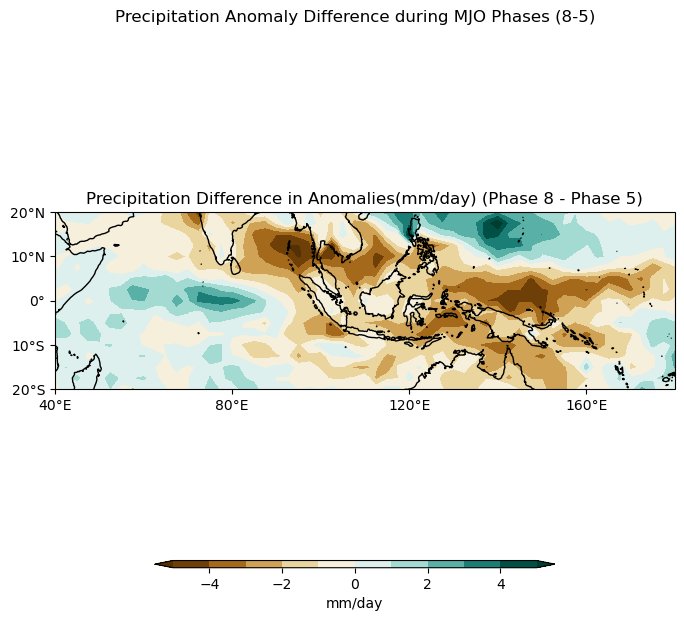

In [91]:
clevs = np.arange(-5.0, 5.1, 1)  # Define contour levels for precipitation anomalies

# Define the figure and axes for the subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),
                        subplot_kw={'projection': ccrs.PlateCarree()})  # Set projection for all axes

# Zoom in on MJO region
axs.set_extent([40, 180, -20, 20], crs=ccrs.PlateCarree()) 

# Create the contour plot for the difference
cs = axs.contourf(phase_composites['phase_1']['longitude'].values, phase_composites['phase_1']['latitude'].values, 
                  diff['precip'], clevs, transform=ccrs.PlateCarree(),
                  cmap='BrBG', extend='both')

# Longitude labels
axs.set_xticks(np.arange(40, 181, 40), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
axs.set_yticks(np.arange(-20, 21, 10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter)

# Title for the plot
axs.set_title('Precipitation Difference in Anomalies(mm/day) (Phase 8 - Phase 5)')

# Draw the coastlines
axs.coastlines()

# Add a colorbar at the bottom of the plot
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.012])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='mm/day')

# Show the plot
plt.suptitle('Precipitation Anomaly Difference during MJO Phases (8-5)')
plt.show()

In [92]:
p = 0.05 # 95% confidence level

In [93]:
import numpy as np
from scipy.stats import ttest_ind

# Extract the numpy arrays from the DataArrays
precip_phase_8_vals = phase_anomalies['phase_8']['precip']
precip_phase_5_vals = phase_anomalies['phase_5']['precip']

# Perform t-test across time,lat, and lon dimensions
tstat, pval = ttest_ind(precip_phase_8_vals, precip_phase_5_vals, equal_var=False)

In [94]:
precip_phase_8_vals.shape

(281, 73, 144)

In [95]:
precip_phase_5_vals.shape

(339, 73, 144)

In [96]:
pval

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.02501525, 0.01527338, 0.01792907, ..., 0.03503931, 0.02624099,
        0.02465831],
       [0.08727983, 0.07439996, 0.07405131, ..., 0.31522471, 0.2579454 ,
        0.14675651],
       ...,
       [0.08981031, 0.20842716, 0.23470032, ..., 0.0174865 , 0.02098426,
        0.04415445],
       [0.6780022 , 0.79637097, 0.83714876, ..., 0.4972115 , 0.49315406,
        0.56463593],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [97]:
pval.shape

(73, 144)

In [98]:
#Create mask where pvalue is less than or equal to 0.05
mask_diff = diff.where(pval <= p)

In [99]:
mask_diff

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 144)
Coordinates:
  * latitude   (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    precip     (latitude, longitude) float32 dask.array<chunksize=(73, 144), meta=np.ndarray>

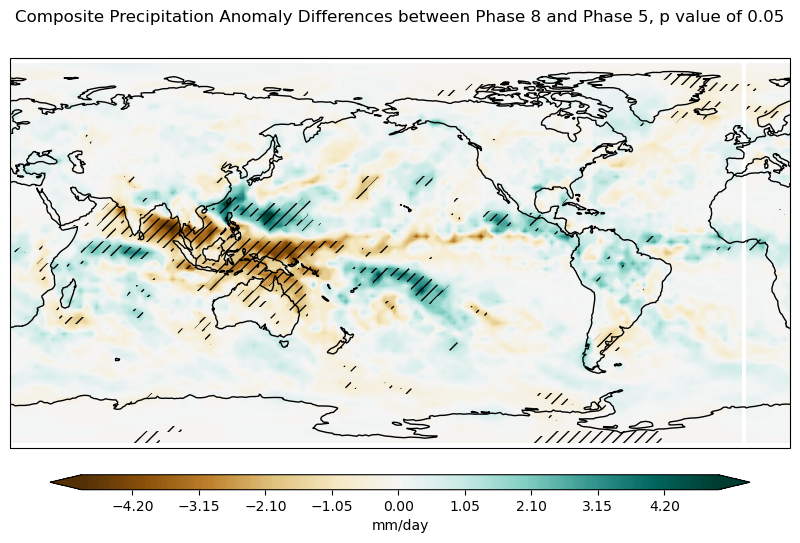

In [100]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Define contour levels for precipitation anomalies
labels = ['Phase 8 vs. Phase 5']
clevs = np.arange(-5, 5.1, 0.05)
hatch_levs = [0]

# Define the figure and axis for the plot
fig, axs = plt.subplots(nrows=1, ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200.0)},
                        figsize=(10, 6))



# Compute the difference (Phase 5 - Phase 1)
data = diff['precip']

# Mask data where significant (True for areas to be highlighted)
mask_data = mask_diff['precip']

# Get the longitude and latitude values
lons = phase_composites['phase_8']['longitude'].values  # Longitude coordinates
lats = phase_composites['phase_5']['latitude'].values  # Latitude coordinates

# Contour plot for the difference (Phase 5 - Phase 1)
cs = axs.contourf(lons, lats, data, clevs, transform=ccrs.PlateCarree(),
                  cmap='BrBG', extend='both')

# Overlay stippling where p value is less than 0.05
ss = axs.contourf(lons, lats, mask_data, levels=[0, 1],
                  transform=ccrs.PlateCarree(), colors=['None'],
                  hatches=['///', ''], extend='both')

# Draw the coastlines
axs.coastlines()

# Adjust the layout to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom
cbar_ax = fig.add_axes([0.15, 0.18, 0.7, 0.025])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='mm/day')

# Add a big title at the top
plt.suptitle('Composite Precipitation Anomaly Differences between Phase 8 and Phase 5, p value of 0.05')

# Show the plot
plt.show()